In [ ]:
import os
import numpy as np
import pandas as pd
import click

from src import pipeline
from src.processing.data_management import (load_dataset, save_pipeline)
from src.config import config, logging_config
from src import pipeline
from src import __version__ as _version
from src.visualization import visualize
##
from sklearn.model_selection import train_test_split
from hyperopt import Trials, STATUS_OK,STATUS_FAIL, tpe, hp, fmin, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

from pandas_profiling import ProfileReport
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

from datetime import datetime
import joblib
import pickle

from functools import partial
import warnings

In [2]:
# read training data
data = load_dataset(file_name=config.TRAINING_DATA_FILE)

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#convert variable in binary >150k; <=150k
data[config.cfg.train.col_label]=np.where(data[config.cfg.train.col_label] >150_000, 1, 0)

In [5]:
data[config.cfg.train.col_label].value_counts()

1    841
0    619
Name: SalePrice, dtype: int64

In [6]:
#You can uncomment these lines if you have a mlflow server tracking

#os.environ["MLFLOW_TRACKING_USERNAME"]=mlflow_user
#os.environ["MLFLOW_TRACKING_PASSWORD"]=mlflow_password
#mlflow.set_tracking_uri(mlflow_uri)

In [7]:
experiment_name="house_price_experiment_hyperopt"
mlflow.set_experiment(experiment_name)

# Hyperopt

https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt

Diving in:
  - **fmin** - central function of `hyperopt`, it performs guided search for a function minimum. It returns the point from parameters hyperspace that yielded the lowest loss. Most important arguments are:
    - *fn* - function to minimize. Must accept a sample from parameters hyperspace and return real number (it might also return a dictionary, which has to contain two mandatory records: *loss* and *status*. Other elements you can design youself, if you want to, say, keep track of some other value during optimization. More on that later);
    - *space* - parameters hyperspace to sample from;
    - *algo* - algorithm which suggests new point given the points history. There are two options - `tpe.suggest` (guided search) and `tpe.rand.suggest` (essentially random search. If you want it);
    - *max_evals* - number of points to sample;
    - *trials* - object of class `Trial` to keep track of optimization history;
    - *rstate* - pseudo-random generator seed, analogous to `random_state` from `sklearn`, for reproducibility;
    - *show_progressbar* - well, kind of explains itself, doesn't it?
  - **hp** - submodule to construct parameters hyperspace;
  - **tpe** - submodule, which component `tpe.suggest` is the heart on hyperopt. It is an algorithm for guided points sampling, named Tree of Parzen Estimators;
  - **Trials** - class, instances of which keep track of entire optimization process (stuff like parameters values, loss values, etc.);
  - **space_eval** (*optional*) - sometimes useful for restoring parameters values from hyperspace in case of complex hyperspaces;
  - **scope** - (*optional*) - submodule, among other things used for parameters type transformation. Say, you draw something from normal distribution, which comes out as `float`, but your model accepts only integer types - `scope` rushes for help;
  - **sample** - (*optional*) - function to draw sample from hyperspace. Not required, but useful for testing whether you described your hyperspace correctly before running `fmin`.

### Set pipeline for optimizing

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn import preprocessing, impute
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier

from src.processing import preprocessors as pp



In [9]:
hp_space = {

    'clf_type': hp.choice('clf_type', [
        {
            'type': 'tree',
            'numerical_columns': config.cfg.train.numerical_columns,
            'categorical_columns': config.cfg.train.categorical_columns,
            'preprocessing': {
                'numerical_imputer': hp.choice('tree.numerical_imputer', [impute.SimpleImputer(strategy='mean')]),
                'poly':  hp.choice('tree.polinomial_features', [None, preprocessing.PolynomialFeatures(degree=2),  preprocessing.PolynomialFeatures(interaction_only=True) ]),
                'numerical_scaler': hp.choice('tree.numerical_scaler', [None, preprocessing.RobustScaler(), preprocessing.MinMaxScaler(), preprocessing.PowerTransformer()]),
                'categorical_imputer': hp.choice('tree.categorical_imputer', [impute.SimpleImputer(strategy='most_frequent')]),
                'categorical_encoder': hp.choice('tree.categorical_encoder', [preprocessing.OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')])
                                },
            "clf": {
                'max_depth': hp.choice('tree.max_depth', range(5, 30, 1)),
                'n_estimators': hp.choice('tree.n_estimators', range(20, 1000, 5)),
                'class_weight': hp.choice('tree.class_weight', ['balanced', 'balanced_subsample']),
                'max_features': hp.choice('tree.max_features', ['auto', 'sqrt', "log2"],),
                'min_samples_split':  hp.choice('tree.min_samples_split', range(2, 100, 1)),
                'min_samples_leaf':  hp.choice('tree.min_samples_leaf', range(2, 10, 1)),
                'bootstrap':  hp.choice('tree.bootstrap', [True, False]),
                'max_leaf_nodes': hp.choice('max_leaf_nodes', [
                    {
                        'max_leaf_nodes': None
                    },
                    {
                        'max_leaf_nodes': ho_scope.int(hp.quniform('max_leaf_nodes_constrained', 100, 500, q=100))
                    }
                ]),
            }
        },
        {
            'type': 'logistic',
            'numerical_columns': config.cfg.train.numerical_columns,
            'categorical_columns': config.cfg.train.categorical_columns,
            'preprocessing': {
                'numerical_imputer': hp.choice('logistic.numerical_imputer', [ impute.SimpleImputer(strategy='mean')]),
                'poly':  hp.choice('logistic.polinomial_features', [None, preprocessing.PolynomialFeatures(degree=2),  preprocessing.PolynomialFeatures(interaction_only=True) ]),
                'numerical_scaler': hp.choice('logistic.numerical_scaler', [None, preprocessing.RobustScaler(), preprocessing.MinMaxScaler(), preprocessing.PowerTransformer()]),
                'categorical_imputer': hp.choice('logistic.categorical_imputer', [impute.SimpleImputer(strategy='most_frequent')]),
                'categorical_encoder': hp.choice('logistic.categorical_encoder', [preprocessing.OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')])

            },
            'clf': {
                'C': hp.loguniform('logistic.C', -4.0*np.log(10.0), 4.0*np.log(10.0)),
                'class_weight': hp.choice('logistic.class_weight', [None, 'balanced']),
                'penalty': hp.choice('logistic.penalty', ['l2', 'none'])
            }
        }
    ])
}

def f_clf(hps):
    """
    Constructs estimator

    Parameters:
    ----------------
    hps : sample point from search space

    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """

    # Assembing pipeline
    num_transformer = Pipeline(steps=[
        ('imputer',  hps["clf_type"]['preprocessing']['numerical_imputer']),
        ('poly',  hps["clf_type"]['preprocessing']['poly']),
        ('scaler', hps["clf_type"]['preprocessing']['numerical_scaler'])
    ])

    cat_transformer = Pipeline(steps=[
        ('imputer', hps["clf_type"]['preprocessing']['categorical_imputer']),
        ('encoder', hps["clf_type"]['preprocessing']['categorical_encoder'])
    ])

    pipeline_procesado = ColumnTransformer(transformers=[
        ('numerical_preprocessing', num_transformer,
         hps["clf_type"]["numerical_columns"]),
        ('categorical_preprocessing', cat_transformer,
         hps["clf_type"]["categorical_columns"])
    ],
        remainder='drop',
        verbose=True)


    if hps['clf_type']['type'] == 'tree':

        pipeline = Pipeline([
            ("transform_inputs", pipeline_procesado),
            ("classifier", RandomForestClassifier(
                **f_unpack_dict(hps['clf_type']['clf'])))
        ])

    elif hps['clf_type']['type'] == 'logistic':

        pipeline = Pipeline([
            ("transform_inputs", pipeline_procesado),
            ("classifier", LogisticRegression(max_iter=10000,
                **hps['clf_type']['clf']))
        ])

    else:
        raise KeyError('Unknown classifier type hyperparameter value: {0}'.format(
            hps['clf_type']['type']))

    return pipeline



In [10]:
ho_sample(hp_space)["clf_type"]

{'categorical_columns': ('MSZoning',
  'Neighborhood',
  'RoofStyle',
  'MasVnrType',
  'BsmtQual',
  'BsmtExposure',
  'HeatingQC',
  'CentralAir',
  'KitchenQual',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'PavedDrive'),
 'clf': {'bootstrap': True,
  'class_weight': 'balanced_subsample',
  'max_depth': 22,
  'max_features': 'sqrt',
  'max_leaf_nodes': {'max_leaf_nodes': 500},
  'min_samples_leaf': 2,
  'min_samples_split': 25,
  'n_estimators': 915},
 'numerical_columns': ('MSSubClass',
  'OverallQual',
  'OverallCond',
  '1stFlrSF',
  'GrLivArea',
  'BsmtFullBath',
  'Fireplaces',
  'GarageCars',
  'LotFrontage'),
 'preprocessing': {'categorical_encoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
  'categorical_imputer': SimpleImputer(strategy='most_frequent'),
  'numerical_imputer': SimpleImputer(),
  'numerical_scaler': MinMaxScaler(),
  'poly': PolynomialFeatures()},
 'type': 'tree'}

In [11]:
def f_wrap_space_eval(hp_space, trial):
    """
    Utility function for more consise optimization history extraction
    
    Parameters:
    ----------------
    hp_space : hyperspace from which points are sampled
    trial : hyperopt.Trials object
    
    Returns:
    ----------------
    : dict(
        k: v
    ), where k - label of hyperparameter, v - value of hyperparameter in trial
    """
    
    return space_eval(hp_space, {k: v[0] for (k, v) in trial['misc']['vals'].items() if len(v) > 0})


def f_unpack_dict(dct):
    """
    Unpacks all sub-dictionaries in given dictionary recursively. There should be no duplicated keys 
    across all nested subdictionaries, or some instances will be lost without warning
    
    Parameters:
    ----------------
    dct : dictionary to unpack
    
    Returns:
    ----------------
    : unpacked dictionary
    """
    
    res = {}
    for (k, v) in dct.items():
        if isinstance(v, dict):
            res = {**res, **f_unpack_dict(v)}
        else:
            res[k] = v
            
    return res

def f_clf(hps):
    """
    Constructs estimator

    Parameters:
    ----------------
    hps : sample point from search space

    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """

    # Assembing pipeline
    num_transformer = Pipeline(steps=[
        ('imputer',  hps["clf_type"]['preprocessing']['numerical_imputer']),
        ('poly',  hps["clf_type"]['preprocessing']['poly']),
        ('scaler', hps["clf_type"]['preprocessing']['numerical_scaler'])
    ])

    cat_transformer = Pipeline(steps=[
        ('imputer', hps["clf_type"]['preprocessing']['categorical_imputer']),
        ('encoder', hps["clf_type"]['preprocessing']['categorical_encoder'])
    ])

    pipeline_procesado = ColumnTransformer(transformers=[
        ('numerical_preprocessing', num_transformer,
         hps["clf_type"]["numerical_columns"]),
        ('categorical_preprocessing', cat_transformer,
         hps["clf_type"]["categorical_columns"])
    ],
        remainder='drop',
        verbose=True)


    if hps['clf_type']['type'] == 'tree':

        pipeline = Pipeline([
            ("transform_inputs", pipeline_procesado),
            ("classifier", RandomForestClassifier(
                **f_unpack_dict(hps['clf_type']['clf'])))
        ])

    elif hps['clf_type']['type'] == 'logistic':

        pipeline = Pipeline([
            ("transform_inputs", pipeline_procesado),
            ("classifier", LogisticRegression(max_iter=1000,
                **hps['clf_type']['clf']))
        ])

    else:
        raise KeyError('Unknown classifier type hyperparameter value: {0}'.format(
            hps['clf_type']['type']))

    return pipeline




In [15]:
def f_to_min(hps, df_train, target, numerical_columns, categorical_columns, metrics, tracking_global_scores, 
             main_metric, ml_flow_run_name, ncv=5, df_test=None, 
             output_directory=config.PACKAGE_ROOT / 'reports' ):
    """
    Target function for optimization

    Parameters:
    ----------------
    hps : sample point from search space
    X : feature matrix
    y : target array
    ncv : number of folds for cross-validation

    Returns:
    ----------------
    : dict(
        'loss' : target function value (negative mean cross-validation ROC-AUC score)
        'cv_std' : cross-validation ROC-AUC score standard deviation
        'status' : status of function evaluation
    )
    """
    with mlflow.start_run(run_name=ml_flow_run_name, nested=True) as run:
        model = f_clf(hps)
        cv_res = cross_validate(model, df_train[numerical_columns+categorical_columns],
                                df_train[target], cv=StratifiedKFold(ncv), scoring=metrics, n_jobs=-2)
        
        scores = {metric: cv_res[f'test_{metric}'].mean() for metric in metrics}


        cross_val_mean = scores[main_metric].mean()
        space_eval_dict = f_unpack_dict(space_eval(hps, model))

        # log metrics model
        for metric_name, value in scores.items():
            mlflow.log_metric(metric_name, value)

         # log params model
        mlflow.log_param("classifier", model.named_steps["classifier"])
        for param, value in space_eval_dict.items():
            mlflow.log_param(param, value)

        # checking if any metric is greater than past iterations
        if any([value > tracking_global_scores.get(score) for score, value in scores.items()]):
            for score, value in scores.items():
                tracking_global_scores[score] = value

            model.fit(df_train[numerical_columns + categorical_columns], df_train[target])
            mlflow.sklearn.log_model(model, artifact_path="artifacts")

            model_classification_report = visualize.classification_model_report_summary(data= df_train[numerical_columns + categorical_columns],
                                              target= df_train[target],
                                              model=model,
                                              title_report="Model report",
                                              classes= [0, 1]
                                             ) 
            
            plt.savefig(output_directory / "training_model_report_summary")
            plt.close()
            mlflow.log_artifacts(output_directory)

    return {
        'loss': -cross_val_mean,
        # 'cv_std': cv_res.std(),
        'scores': scores,
        'status': STATUS_OK,
        'model': model,
        'space_eval': space_eval_dict
    }


In [16]:
scoring_metrics_list=['f1', 'roc_auc']
tracking_global_scores = {metric: 0 for metric in scoring_metrics_list} #set up metrics in zero

trials = Trials()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    best_clf = fmin(partial(f_to_min,
                            df_train=data,
                            target=config.cfg.train.col_label,
                            numerical_columns=config.cfg.train.numerical_columns,
                            categorical_columns=config.cfg.train.categorical_columns,
                            metrics=scoring_metrics_list,
                            main_metric="f1",
                            tracking_global_scores=tracking_global_scores,
                            ncv=5,
                            #ml_flow_run_name=datetime.now().strftime("churn_run_%Y%m%d")
                            #ml_flow_run_name=gcs_model_path.split("/")[-1],
                            ml_flow_run_name=experiment_name,
                            #df_test=X_test
                            ),
                        hp_space,
                        algo=tpe.suggest,
                        max_evals=10,
                        trials=trials)

[ColumnTransformer]  (1 of 2) Processing numerical_preprocessing, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing categorical_preprocessing, total=   0.0s
[ColumnTransformer]  (1 of 2) Processing numerical_preprocessing, total=   0.0s  
[ColumnTransformer]  (2 of 2) Processing categorical_preprocessing, total=   0.0s
[ColumnTransformer]  (1 of 2) Processing numerical_preprocessing, total=   0.0s  
[ColumnTransformer]  (2 of 2) Processing categorical_preprocessing, total=   0.0s
[ColumnTransformer]  (1 of 2) Processing numerical_preprocessing, total=   0.0s  
[ColumnTransformer]  (2 of 2) Processing categorical_preprocessing, total=   0.0s
[ColumnTransformer]  (1 of 2) Processing numerical_preprocessing, total=   0.2s  
[ColumnTransformer]  (2 of 2) Processing categorical_preprocessing, total=   0.0s
[ColumnTransformer]  (1 of 2) Processing numerical_preprocessing, total=   0.0s  
[ColumnTransformer]  (2 of 2) Processing categorical_preprocessing, total=   0.0s
[ColumnTransformer

In [17]:
samples = [f_unpack_dict(f_wrap_space_eval(hp_space, x)) for x in trials.trials]

In [18]:
trials.trials[0]["result"]["model"].named_steps

{'transform_inputs': ColumnTransformer(transformers=[('numerical_preprocessing',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('poly', None),
                                                  ('scaler', RobustScaler())]),
                                  ('MSSubClass', 'OverallQual', 'OverallCond',
                                   '1stFlrSF', 'GrLivArea', 'BsmtFullBath',
                                   'Fireplaces', 'GarageCars', 'LotFrontage')),
                                 ('categorical_preprocessing',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
     

In [19]:
optimized_pipeline=trials.best_trial["result"]["model"]

In [20]:
optimized_pipeline.fit(data[config.cfg.train.numerical_columns+config.cfg.train.categorical_columns], 
                       data[config.cfg.train.col_label])

[ColumnTransformer]  (1 of 2) Processing numerical_preprocessing, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing categorical_preprocessing, total=   0.0s


Pipeline(steps=[('transform_inputs',
                 ColumnTransformer(transformers=[('numerical_preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ('MSSubClass', 'OverallQual',
                                                   'OverallCond', '1stFlrSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'Fireplaces', 'GarageCars',
                                                   'LotFrontage')),
          

/Users/diegofernandezgil/anaconda3/envs/cookiecutter_dev/lib/python3.8/site-packages/yellowbrick/classifier/classification_report.py:286: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # TODO: Could use self.fig now


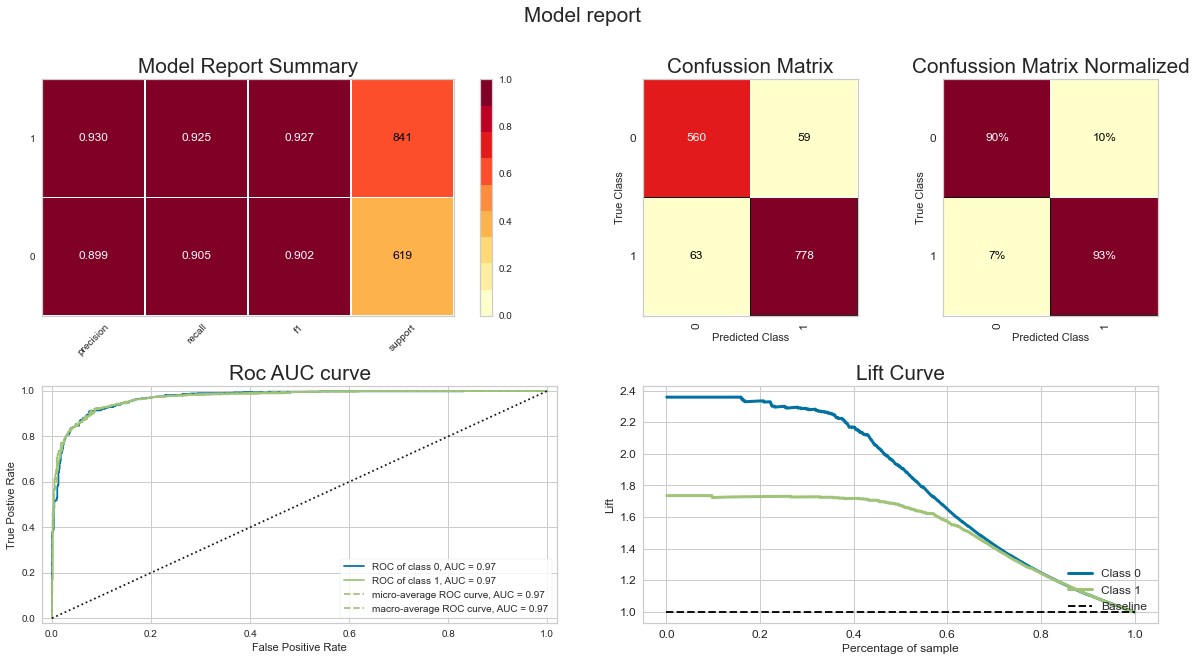

In [22]:
visualize.classification_model_report_summary(data= data,
                                              target= data[config.cfg.train.col_label],
                                              model= optimized_pipeline,
                                              title_report="Model report",
                                              classes= [0, 1]
                                             ) 

In [23]:
!mlflow ui

[2021-01-11 16:40:19 +0100] [14362] [INFO] Starting gunicorn 20.0.4
[2021-01-11 16:40:19 +0100] [14362] [INFO] Listening at: http://127.0.0.1:5000 (14362)
[2021-01-11 16:40:19 +0100] [14362] [INFO] Using worker: sync
[2021-01-11 16:40:19 +0100] [14364] [INFO] Booting worker with pid: 14364
^C
[2021-01-11 16:40:58 +0100] [14362] [INFO] Handling signal: int
[2021-01-11 16:40:58 +0100] [14364] [INFO] Worker exiting (pid: 14364)
